<a href="https://colab.research.google.com/github/rika-27/DMT/blob/master/SPAM_HAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
def remove_spaces(x): 
  while('' in x) : 
    x.remove('')
  return x

def stems_the_word(word):
  if word.isalpha():
    try:
      if word in ["ü", "Ü"]:
        return stem_dict[ps.stem('u')]
      elif word in ["É","é"]:
        return stem_dict[ps.stem('e')]
      elif word in ["nìte"]:
        return stem_dict[ps.stem('nite')]
      return stem_dict[ps.stem(word.lower())]
    except KeyError:
      return stem_dict[ps.stem('or')]
  else:
    return -10

def pad_me(x):
  zeros_list = np.zeros(39)
  zeros_list[:len(x)] = x
  return zeros_list


ps = PorterStemmer()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


89943 -> 6483
Preparation of the stem dictionary complete!


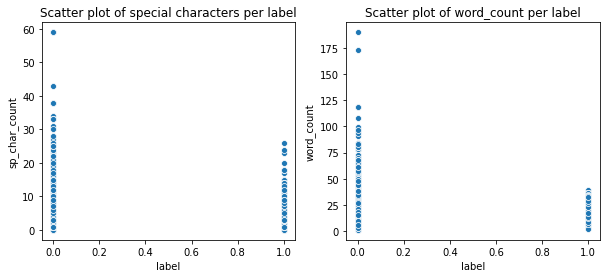

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,label,text,sp_char_count,word_count,conv_text
0,0,Go until jurong point crazy Available only in ...,1,1,"[0.0, 0.00015424957581366652, 0.00030849915162..."
1,0,Ok lar Joking wif u oni,1,1,"[0.00308499151627333, 0.003239241092086997, 0...."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,1,1,"[0.004010488971155329, 0.0041647385469689956, ..."
3,0,U dun say so early hor U c already then say,1,1,"[0.0037019898195279964, 0.007866728366496992, ..."
4,0,Nah I don t think he goes to usf he lives arou...,1,1,"[0.008946475397192658, 0.009100724973006324, 0..."
...,...,...,...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...,1,1,"[0.024525682554372975, 0.014807959278111986, 0..."
5570,0,Will ü b going to esplanade fr home,1,1,"[0.031004164738546967, 0.0037019898195279964, ..."
5571,0,Pity was in mood for that So any other suggest...,1,1,"[0.9998457504241863, 0.05059386086688262, 0.00..."
5572,0,The guy did some bitching but I acted like i d...,1,1,"[0.022366188492981644, 0.14684559617461052, 0...."


In [0]:
df = pd.read_csv('SmsCollection.csv', sep='Noel')
df.label = pd.factorize(df.label)[0]
df = pd.concat([df, pd.DataFrame({'sp_char_count': df.text.apply(lambda x: [(s.isalpha() or s.isdigit() or s == ' ' ) for s in x].count(False))})], axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(df.label, df.sp_char_count, ax=ax1)
ax1.set_title('Scatter plot of special characters per label')
df.text = df.text.str.replace('\W', ' ', regex = True)
df.text = df.text.str.split(' ').apply(lambda x: ' '.join(map(str, remove_spaces(x))))
df = pd.concat([df, pd.DataFrame({'word_count' :df.text.str.split(' ').apply(lambda x: len(x))})], axis = 1)
sns.scatterplot(df.label, df.word_count, ax=ax2)
ax2.set_title('Scatter plot of word_count per label')
unique_words = list(df.text.str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())
stem = []
for word in unique_words:
  stem.append(ps.stem(word))
stem = list(dict.fromkeys(stem))
print(len(unique_words), '->' ,len(stem))
stem_dict = dict.fromkeys(stem)
for key in stem_dict.keys():
  stem_dict[key] = stem.index(key)
print('Preparation of the stem dictionary complete!')
df = pd.concat([df,pd.DataFrame({'conv_text': df.text.str.split(' ').apply(lambda x: [stems_the_word(word) for word in x])})], axis=1)
# df = pd.concat([df, pd.DataFrame({'number_count': df.conv_text.apply(lambda x: x.count(-10))})], axis = 1)
# sns.scatterplot(df.label, df.number_count, ax=ax3)
# ax3.set_title('Scatter plot of number_count per label')
plt.show()
df.word_count.loc[df.word_count <= 39] = 1
df.word_count.loc[df.word_count > 1] = 0
df.sp_char_count.loc[df.sp_char_count <= 26] = 1
df.sp_char_count.loc[df.sp_char_count > 1] = 0
df['conv_text'] = df.conv_text.apply(lambda x: x[:39])
df['conv_text'] =  df.conv_text.apply(lambda x: pad_me(x))
df['conv_text'] = df.conv_text.apply(lambda x: x / 6483)
df

In [0]:
X_val= df[['sp_char_count', 'word_count']].values
x = df['conv_text'].values
X = []
for i in range(X_val.shape[0]):
  X.append(np.append(X_val[i], x[i][:]))
y = df.label.values
len(X), len(y)


(5574, 5574)

In [0]:
# X = list(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [0]:
model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam',
                                             alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                                             power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                                             warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                                             validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

In [0]:
mlp = model.fit(list(X_train), y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
y_pred = model.predict(X_test)
print('accuracy score', accuracy_score(y_test, y_pred)*100)

accuracy score 86.54708520179372
